## Setup

In [2]:
import sys
sys.path.insert(0, '/home/rhaksar/Desktop/eelfff')

In [3]:
import copy
from datetime import datetime
from FireSimulator import *
from FireSimulatorUtilities import *
import glob
import itertools
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

# Heuristic solution

hand-tuned function to generate actions for agents

In [4]:
def heuristic(agent_id, pos, img_st, seen_fire, center, close_agent_id, close_pos):

    traj = []
    actions = []
    traj.append((pos[0],pos[1]))
    img_dim = img_st.shape[0]
    fire_neigh = [(-1,0),(0,-1),(1,0),(0,1)]
    move_neigh = [(-1,0),(1,0),(-1,1),(0,1),(1,1),(-1,-1),(0,-1),(1,-1)] #excluded (0,0)
    action_set = [4,1,2,3,5,8,7,6]
    
    dists = None
    x,y = pos

    r = img_dim//2
    c = img_dim//2

    if img_st[r,c] in [1,2] or seen_fire:
        seen_fire = True
        dists = []
        
        cen_vec = np.array([x-center,y-center])
        cen_vec = cen_vec/np.linalg.norm(cen_vec)
        for a in range(1,9):
        #for a in [2,5,7,4]:
            new_pos = actions_to_trajectory(traj[-1],[a])[1]

            rl = -new_pos[1] + y + img_dim//2
            cl = new_pos[0] -x + img_dim//2
            #if a in [1,3,8,6] and img_st[rl,cl] in [0]:
            #    continue

            move_vec = np.array([new_pos[0]-x,new_pos[1]-y])
            if a != 0:
                move_vec = move_vec/np.linalg.norm(move_vec)
            dists.append((np.cross(cen_vec,move_vec),new_pos,a))

        cir_pos = min(dists)[1]
        cir_act = min(dists)[2]

        ri = -cir_pos[1] + y + img_dim//2
        ci = cir_pos[0] -x + img_dim//2

        left_act = None
        if cir_act==1:
            left_act = [6,4]
            #left_act = [4]
            righ_act = [2]
        elif cir_act==2:
            left_act = [4,1]
            #left_act = [1]
            righ_act = [3]
        elif cir_act==3:
            left_act = [1,2]
            #left_act = [2]
            righ_act = [5]
        elif cir_act==5:
            left_act = [2,3]
            #left_act = [3]
            righ_act = [8]
        elif cir_act==8:
            left_act = [3,5]
            #left_act = [5]
            righ_act = [7]
        elif cir_act==7:
            left_act = [5,8]
            #left_act = [8]
            righ_act = [6]
        elif cir_act==6:
            left_act = [8,7]
            #left_act = [7]
            righ_act = [4]
        elif cir_act==4:
            left_act = [7,6]
            #left_act = [6]
            righ_act = [1]

        out = False
        for a in left_act:
            new_pos = actions_to_trajectory(traj[-1],[a])[1]
            ro = -new_pos[1] + y + img_dim//2
            co = new_pos[0] - x + img_dim//2
            if img_st[ro,co] in [1]:
                cir_pos = new_pos
                cir_act = a
                out = True
                break

        if not out:
            for a in left_act:
                new_pos = actions_to_trajectory(traj[-1],[a])[1]
                ro = -new_pos[1] + y + img_dim//2
                co = new_pos[0] - x + img_dim//2
                if img_st[ro,co] in [2]:
                    cir_pos = new_pos
                    cir_act = a
                    out = True
                    break

        counter = 0
        for (dr,dc) in move_neigh:
            rn = ri + dr
            cn = ci + dc
            if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn] in [0]:
                counter += 1

        if not out and img_st[ri,ci] in [0] and counter>=6:
            for a in righ_act:
                new_pos = actions_to_trajectory(traj[-1],[a])[1]
                cir_pos = new_pos
                cir_act = a

        if np.linalg.norm(cir_pos-close_pos,2)<=1 and agent_id > close_agent_id:
            cir_pos = traj[-1]
            cir_act = 0

        traj.append(cir_pos)
        actions.append(cir_act)      

    if not seen_fire:
        dists = []
        #for a in range(9):
        for idx,a in enumerate([2,5,7,4,1,3,8,6]):
            new_pos = actions_to_trajectory(traj[-1],[a])[1]
            incntv = -(8-idx)*0.1
            dists.append((np.abs(center-new_pos[0])+np.abs(center-new_pos[1])+incntv,new_pos,a))

        #print(dists)
        #print()
        score, pos, act = min(dists)
        traj.append(pos)
        actions.append(act)
        
    return traj, actions, seen_fire

## Benchmark heuristic solution by running many simulations

In [6]:
grid_size = 50
num_agents = 50
seeds = range(1000)

act_repeat = 6
center = (grid_size+1)/2
dp = 0.15/0.2763

# agent initialization parameters
spawn_loc = np.arange(grid_size//3//2,grid_size,grid_size//3)
perturbs = np.arange(-grid_size//3//2+1,grid_size//3//2+1,1)

results = []

In [ ]:
tic = time.clock()
# run many simulations
for i,s in enumerate(seeds):
    np.random.seed(1000+s)

    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    sim.step([])
    num_init_fires = len(sim.fires)

    # initialize agent positions
    # n = np.squeeze(np.random.choice(num_agents, 1))
    n = num_agents
    agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
    agent_pos = agent_pos.astype(np.int32)

    control = []
    repeat_cntr = 1
    agent_sf = {}
    for k in range(n):
        agent_sf[k] = False

    # run simulation
    while not sim.end:
    
        new_agent_pos = np.zeros((n,2)).astype(np.int32)

        # generate control for each agent
        for k in range(n):
            # generate image
            img, img_st, hasfire = CreateImageBW(sim.state, agent_pos[k,:])

            # generate action and resulting trajectory using heuristic
            dists = [(np.linalg.norm(agent_pos[k,:]-pos,1),i,pos) for i,pos in enumerate(agent_pos) if i!=k]
            min_dist, min_id, min_pos = min(dists)
            traj, act, sf = heuristic(k, agent_pos[k,:], img_st, agent_sf[k], center, min_id, min_pos)
            agent_sf[k] = sf

            # generate control from trajectory
            control.extend(FindGridIntersections(sim.state, traj))

            # store agent's new position
            new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]

        # remove duplicates from control sequence
        control = list(set(control))

        # step simulator
        if repeat_cntr % act_repeat == 0:
            sim.step(control, dbeta=dp)
            control = []
            repeat_cntr = 1
        else:
            repeat_cntr += 1

        # update agent position
        agent_pos = new_agent_pos

    #print("[seed %3d] episode stats: %s, %f" %(s,sim.stats,sim.stats[0]/np.sum(sim.stats)))
    #print('# unique agents left = %d' %(len(set(tuple(x) for x in agent_pos))))
    if (i+1) % 10 == 0:
        print("finished %d simulations" % (i+1))
    
    # store simulation result
    results.append(sim.stats[2]/np.sum(sim.stats)) # fraction of burned trees

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" %(toc-tic,(toc-tic)/60))

finished 10 simulations
finished 20 simulations
finished 30 simulations
finished 40 simulations
finished 50 simulations
finished 60 simulations
finished 70 simulations
finished 80 simulations
finished 90 simulations
finished 100 simulations
finished 110 simulations
finished 120 simulations
finished 130 simulations
finished 140 simulations
finished 150 simulations
finished 160 simulations
finished 170 simulations
finished 180 simulations
finished 190 simulations
finished 200 simulations
finished 210 simulations
finished 220 simulations
finished 230 simulations
finished 240 simulations
finished 250 simulations
finished 260 simulations
finished 270 simulations
finished 280 simulations
finished 290 simulations
finished 300 simulations
finished 310 simulations
finished 320 simulations
finished 330 simulations
finished 340 simulations
finished 350 simulations
finished 360 simulations
finished 370 simulations
finished 380 simulations
finished 390 simulations
finished 400 simulations
finished 

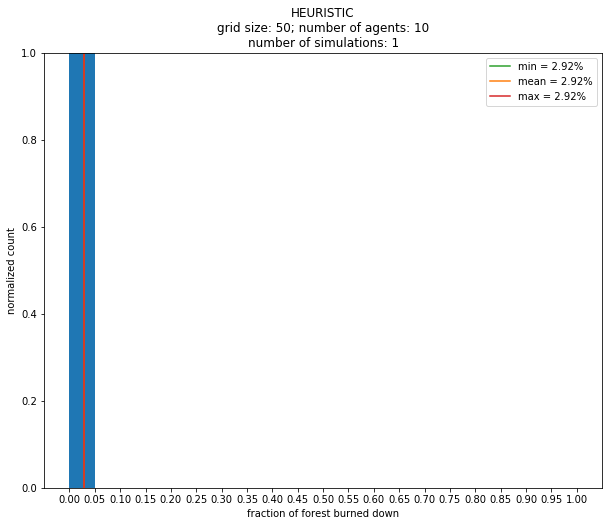

In [7]:
plt.figure()
weights = np.ones_like(results)/float(len(results))
splits, _, _ = plt.hist(results, bins=np.arange(0,1+0.05,0.05), normed=False, weights=weights)
plt.axvline(np.amin(results),color="C2",label="min = %0.2f%%" % (np.amin(results)*100))
plt.axvline(np.mean(results),color="C1",label="mean = %0.2f%%" %(np.mean(results)*100))
plt.axvline(np.amax(results),color="C3",label="max = %0.2f%%" %(np.amax(results)*100))

plt.ylim([0,1])
plt.xticks(np.arange(0,1+0.05,0.05))
plt.xlabel('fraction of forest burned down')
plt.ylabel('normalized count')
plt.title('HEURISTIC\ngrid size: %d; number of agents: %d\nnumber of simulations: %d' %(grid_size,n,len(results)))
plt.legend(loc=1)

# plt.savefig('heuristic.png', bbox_inches='tight')

In [8]:
splits

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [9]:
np.mean(results)

0.0292

In [ ]:
with open('heuristic_%d+%d+%d+%d.pkl' %(grid_size,num_agents,num_init_fires,len(seeds)), 'wb') as fp:
    pickle.dump(results, fp)

In [11]:
win_results = [x for x in results if x <= np.mean(results)]
print('fraction of wins: %0.2f' % (100*len(win_results)/len(results)))
print('win mean: %0.2f' %(np.mean(win_results)*100))

fraction of wins: 100.00
win mean: 2.92
